<img src="saclay_center.png" width="800" height="600">

# French Web Domain Classification

<i> Authors : Siwar ABBES, Dina ABED, Elyess Karray

## Introduction
The goal of this project is to solve a web domain classification problem. We have 8 different categories: business/finance, education/research, entertainment,
health/medical, news/press, politics/government/law, sports
and tech/science.

Text based methods and Graph based methods on
web pages document for classification tasks are of many studies.
In this project, we implemented different prepossessing strategies to deal with our data and we explored different methods of machine learning and deep learning to solve a web domain classification problem. We present all the methods deployed and the best scored method.



## 1.Data Collection


The dataset of French domains was generated from a large crawl of the French web that was performed
by the DaSciM team. We are given the following files:
1. edgelist.txt: a subgraph of the French web graph. It has 28, 002 vertices and 319, 498 weighted,
directed edges. Nodes correspond to domain ids and there is an edge between two nodes if there
is a hyperlink from at least one page of the source domain to at least one page of the target domain.
2. text directory: for each domain, a .txt file containing the text of all the pages of the domain. The
text was extracted from the HTML source code of the pages.
3. train.csv: 2, 125 labeled domain ids. One domain id and category per row. The list of categories is
shown in Table 1.
4. test.csv: 560 domain ids the category of which is to be predicted. One domain id per row.
5. graph baseline.csv: output of the provided graph baseline. 

### Importing the Libraries

In [1]:
#!python -m spacy download fr

In [164]:
#Load Data
#import networ*kx as nx

import pandas as pd
import os
from os import path

#Feature Extraction
import emoji
from string import digits

#Preprocessing
from nltk.corpus import stopwords
import re
import string
from bs4 import BeautifulSoup
import nltk
from nltk.stem.snowball import FrenchStemmer
nltk.download('wordnet')
import spacy


# EDA
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Embedding
import word2vec
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

import gensim
from unidecode import unidecode
from gensim.models import KeyedVectors
from gensim.models.doc2vec import Doc2Vec
from gensim.models import TfidfModel
from gensim.corpora import Dictionary
from nltk.tokenize import word_tokenize

#Model 
from keras.preprocessing import sequence
from sklearn.base import BaseEstimator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Concatenate, Dense, MaxPooling1D, LSTM
from tensorflow.keras.initializers import Constant
from sklearn import preprocessing
pattern = re.compile('[\W_]+')

#metric
from sklearn.metrics import log_loss


#Others
import numpy as np
from sklearn.model_selection import train_test_split
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")
from textblob import TextBlob
import pickle
from sklearn.metrics import log_loss


[nltk_data] Downloading package wordnet to /Users/siwar/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Loading data

In [3]:
# %load ../../utils/read_data.py


def get_data_full(data_path='./data/'):
    with open(path.join(data_path, "train.csv"), 'r') as f:
        train_data = f.read().splitlines()
    with open(path.join(data_path, "test.csv"), 'r') as f:
        test_hosts = f.read().splitlines()

    train_hosts = list()
    y_train = list()
    for row in train_data:
        host, label = row.split(",")
        train_hosts.append(host)
        y_train.append(label.lower())

    # Text data
    # Load the textual content of a set of webpages for each host into the dictionary "data".
    # The encoding parameter is required since the majority of our data is french.
    text = dict()
    text_path = path.join(data_path, 'text/')
    filenames = os.listdir(text_path)

    for filename in filenames:
        try:
            with open(path.join(text_path, filename), encoding='utf-8') as f:
                text[filename] = f.read().replace("\n", "").lower()
        except:
            with open(path.join(text_path, filename), encoding='latin-1') as f:
                text[filename] = f.read().replace("\n", "").lower()

    X_train = list()
    for host in train_hosts:
        if host in text:
            X_train.append([host, text[host]])
        else:
            X_train.append([host, ''])
    # Get textual content of web hosts of the test set
    X_test = list()
    for host in test_hosts:
        if host in text:
            X_test.append([host, text[host]])
        else:
            X_test.append([host, ''])
    return X_train, y_train, X_test, test_hosts


In [6]:
X_train, y_train, X_test, test_hosts = get_data_full(data_path='data/') 

In [7]:
data_train = pd.DataFrame({'text': X_train,'category': y_train,}) # Convert to Dataframe
data_train[['train_host','text']] = pd.DataFrame(data_train.text.values.tolist(), index= data_train.index)
data_train.set_index('train_host', inplace=True)
data_train.head()

,text,category
train_host,,
9032,#polepharma » flux polepharma » flux des commentaires alternate alternate polepharma polepharma ﻿ recherche_________ submit (button) toggle navigation polepharma * polepharma ...,health/medical
5346,301 moved permanently __________________________________________________________________ nginx 301 mov...,entertainment
18778,"(button) fermer en poursuivant votre navigation sans modifier vos paramètres de cookies, vous acceptez l'utilisation des cookies pour disposer de services et d'offres adaptés à vos centre...",entertainment
11939,#hal (button) toggle navigation ccsd * hal + hal + halshs + tel + médihal + liste des portails + + auréhal + api ...,education/research
17502,user-agent: * disallow: disallow: /publishers user-agent: yandex crawl-delay: 3 sitemap: https://www.soft32.com/sitemap.xml télécharger des logiciels gratuits pour windows | soft32 * ac...,tech/science


In [8]:
data_train.isna().sum()

text        0
category    0
dtype: int64

In [9]:
data_train['text'][0][:500]

'   #polepharma » flux polepharma » flux des commentaires alternate   alternate   polepharma   polepharma \ufeff recherche_________ submit   (button) toggle navigation   polepharma     * polepharma          + qui sommes-nous ?          + organigramme          + les chiffres clés          + un réseau     * territoires          + région centre-val de loire          + région normandie          + conseil départemental d’eure&loir          + chartres metropole          + metropole de rouen          + agglo'

In [10]:
data_test = pd.DataFrame({'text': X_test,})
data_test[['test_host','text']] = pd.DataFrame(data_test.text.values.tolist(), index= data_test.index)
data_test.set_index('test_host', inplace=True)
data_test.head()

,text
test_host,
27997,iframe: //www.googletagmanager.com/ns.html?id=gtm-k598bts skip to main content * about * alumni * news & events * give * go griffs * my canisiussearch form search __...
9316,iframe: https://www.googletagmanager.com/ns.html?id=gtm-mhb3554 [p?c1=7&c2=20061681&c3=1000055&cv=2.0&cj=1] poki facebook logo 722k youtube logo 362k ____________________ (button) (bu...
27045,#toutes les astuces beauté ⋅ astuces beauté ⋅ sephora à la une ⋅ astuces beauté ⋅ sephora sephora x richaard ⋅ astuces beauté ⋅ sephora tendance ⋅ astuces beauté ⋅ sephora tutos ⋅ astuces b...
19805,[logodefault.jpg] [etab_juvisy-sur-orge.png] juvisy-sur-orge 01 69 54 27 27 [etab_longjumeau.png] longjumeau 01 64 54 33 33 [etab_orsay.png] orsay 01 69 29 75 75 le ghne [po...
26580,#l'école de demain » flux l'école de demain » flux des commentaires l'école de demain » quand des professeurs d’histoire-géographie renversent leur classe 1/2 flux des commentaires intervie...


In [11]:
text_sample = data_test['text'][10]
text_sample[:500]

'   #hôtel radio » flux hôtel radio » flux des commentaires alternate   alternate   (button)     * fr     * en     * l’hotel          + pourquoi le radio          + nos chambres          + naturellement     * le restaurant          + la carte          + les menus          + déjeuner club     * guide week-end     * offres spéciales          + le séjour « gastronomie & bien-être »          + le séjour « bulles & bulles de champagne »     * offrez le radio     * cours de cuisine          + au coeur '

In [12]:
labels = ['business/finance', 'education/research', 'entertainment', 'health/medical',
          'news/press', 'politics/government/law', 'sports', 'tech/science']

## 2. EDA : Part1

### Imbalance

business/finance           626
entertainment              579
tech/science               290
education/research         209
politics/government/law    200
health/medical              92
news/press                  83
sports                      46
Name: category, dtype: int64


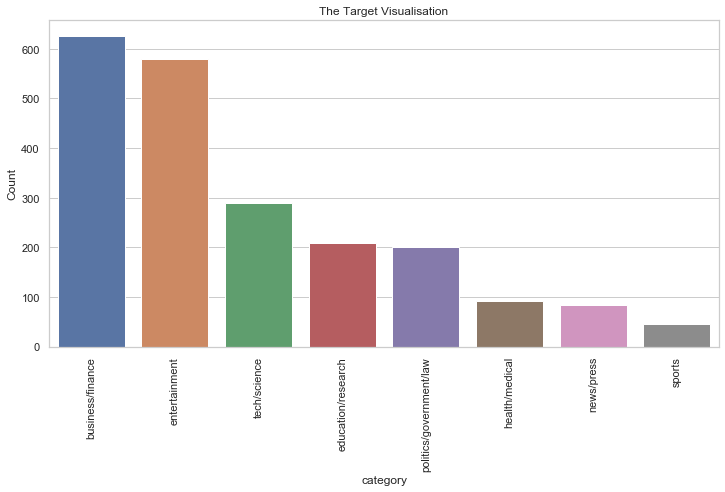

In [31]:
target = data_train["category"].value_counts()
print(target)
target = target.to_frame()
target.columns = ['Count']
target.index.names = ['category']
target['category'] = target.index 
plt.figure(figsize=(12,6))

#Plotting the Target variable
sns.set(style = 'whitegrid', color_codes = True)
sns.barplot(x = 'category', y = 'Count', data = target)
plt.title('The Target Visualisation')
plt.xticks(rotation = 90)
plt.show()

### Distribution of doc lengths

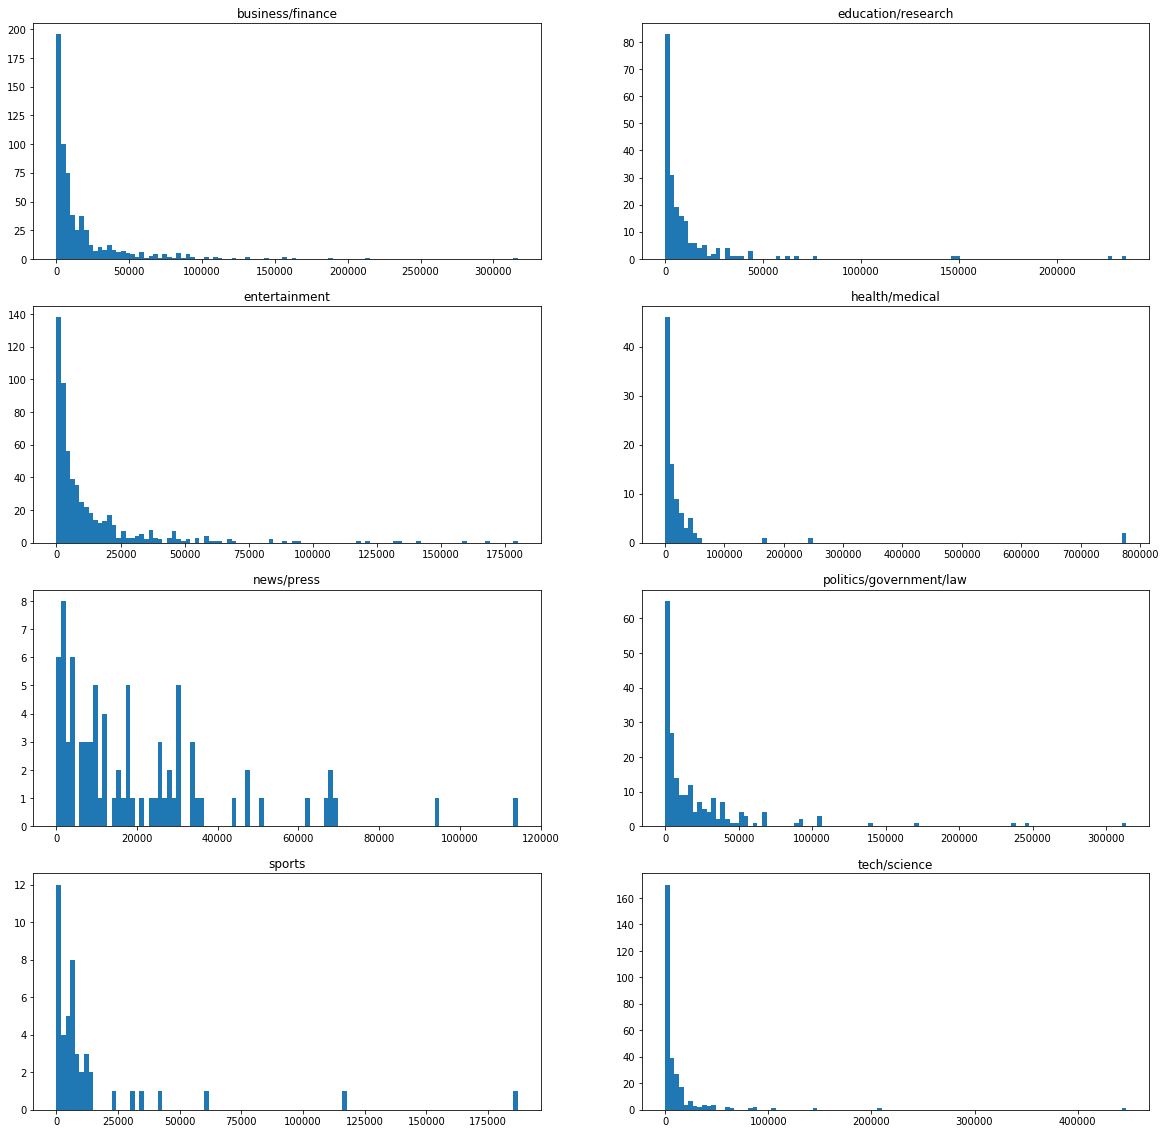

In [26]:
fig, ax = plt.subplots(4, 2, figsize=(20, 20))
for i in range(8):
    lb = labels[i]
    features = []
    for u in range(len(y_train)):
        x = X_train[u]
        if lb == y_train[u]:
            features.append(len(x[1].split(' ')))
    ax[i // 2, i % 2].hist(features, bins=100)
    ax[i // 2, i % 2].set_title(lb)


## 3. Text Feature extraction: Part1

Focusing on the text data to predict the category, we try to
extract more explanatory variables of our texts. The added
features are the following:
    - Number of hashtags in the text
    - Number of users tagged
    - Number of numerical values
    - Numbers of emojis
    - Number of words in a text
    - Average length of the words of the text

#### 1. Number of hashtags

In [13]:
data_train['hashtags_count'] = data_train['text'].apply( lambda x : len( [ x for x in x.split() if x.startswith('#') ]) )
data_test['hashtags_count'] = data_test['text'].apply( lambda x : len( [ x for x in x.split() if x.startswith('#') ]) )

In [14]:
data_train.head()

,text,category,hashtags_count
train_host,,,
9032,#polepharma » flux polepharma » flux des commentaires alternate alternate polepharma polepharma ﻿ recherche_________ submit (button) toggle navigation polepharma * polepharma ...,health/medical,10
5346,301 moved permanently __________________________________________________________________ nginx 301 mov...,entertainment,0
18778,"(button) fermer en poursuivant votre navigation sans modifier vos paramètres de cookies, vous acceptez l'utilisation des cookies pour disposer de services et d'offres adaptés à vos centre...",entertainment,3
11939,#hal (button) toggle navigation ccsd * hal + hal + halshs + tel + médihal + liste des portails + + auréhal + api ...,education/research,2
17502,user-agent: * disallow: disallow: /publishers user-agent: yandex crawl-delay: 3 sitemap: https://www.soft32.com/sitemap.xml télécharger des logiciels gratuits pour windows | soft32 * ac...,tech/science,1


####  2. Number of users tagged 

In [15]:
data_train['users_tagged'] = data_train['text'].apply( lambda x : len( [ x for x in x.split() if x.startswith('@') ]) )
data_test['users_tagged'] = data_test['text'].apply( lambda x : len( [ x for x in x.split() if x.startswith('@') ]) )

data_train.head()

,text,category,hashtags_count,users_tagged
train_host,,,,
9032,#polepharma » flux polepharma » flux des commentaires alternate alternate polepharma polepharma ﻿ recherche_________ submit (button) toggle navigation polepharma * polepharma ...,health/medical,10,8
5346,301 moved permanently __________________________________________________________________ nginx 301 mov...,entertainment,0,0
18778,"(button) fermer en poursuivant votre navigation sans modifier vos paramètres de cookies, vous acceptez l'utilisation des cookies pour disposer de services et d'offres adaptés à vos centre...",entertainment,3,0
11939,#hal (button) toggle navigation ccsd * hal + hal + halshs + tel + médihal + liste des portails + + auréhal + api ...,education/research,2,0
17502,user-agent: * disallow: disallow: /publishers user-agent: yandex crawl-delay: 3 sitemap: https://www.soft32.com/sitemap.xml télécharger des logiciels gratuits pour windows | soft32 * ac...,tech/science,1,0


#### 3. Number of numerical values 

In [16]:
data_train['numeric'] = data_train['text'].apply( lambda x : len( [ x for x in x.split() if x.isdigit() ]) )
data_test['numeric'] = data_test['text'].apply( lambda x : len( [ x for x in x.split() if x.isdigit() ]) )
data_train.head()

,text,category,hashtags_count,users_tagged,numeric
train_host,,,,,
9032,#polepharma » flux polepharma » flux des commentaires alternate alternate polepharma polepharma ﻿ recherche_________ submit (button) toggle navigation polepharma * polepharma ...,health/medical,10,8,348
5346,301 moved permanently __________________________________________________________________ nginx 301 mov...,entertainment,0,0,3
18778,"(button) fermer en poursuivant votre navigation sans modifier vos paramètres de cookies, vous acceptez l'utilisation des cookies pour disposer de services et d'offres adaptés à vos centre...",entertainment,3,0,100
11939,#hal (button) toggle navigation ccsd * hal + hal + halshs + tel + médihal + liste des portails + + auréhal + api ...,education/research,2,0,9
17502,user-agent: * disallow: disallow: /publishers user-agent: yandex crawl-delay: 3 sitemap: https://www.soft32.com/sitemap.xml télécharger des logiciels gratuits pour windows | soft32 * ac...,tech/science,1,0,21


#### 4.Numbers of emojis

In [17]:
def count_emoji(text):

    emoji_list = []
    for word in text:
        if any(char in emoji.UNICODE_EMOJI for char in word):
            emoji_list.append(word)

    return len(emoji_list)

In [18]:
data_train['count_emoji'] = data_train['text'].apply( lambda x: count_emoji(x) )
data_test['count_emoji'] = data_test['text'].apply( lambda x: count_emoji(x) )

In [19]:
data_train.head()

,text,category,hashtags_count,users_tagged,numeric,count_emoji
train_host,,,,,,
9032,#polepharma » flux polepharma » flux des commentaires alternate alternate polepharma polepharma ﻿ recherche_________ submit (button) toggle navigation polepharma * polepharma ...,health/medical,10,8,348,8
5346,301 moved permanently __________________________________________________________________ nginx 301 mov...,entertainment,0,0,3,0
18778,"(button) fermer en poursuivant votre navigation sans modifier vos paramètres de cookies, vous acceptez l'utilisation des cookies pour disposer de services et d'offres adaptés à vos centre...",entertainment,3,0,100,2
11939,#hal (button) toggle navigation ccsd * hal + hal + halshs + tel + médihal + liste des portails + + auréhal + api ...,education/research,2,0,9,0
17502,user-agent: * disallow: disallow: /publishers user-agent: yandex crawl-delay: 3 sitemap: https://www.soft32.com/sitemap.xml télécharger des logiciels gratuits pour windows | soft32 * ac...,tech/science,1,0,21,1


In [20]:
def most_50_freq(text):
    frequency = Counter()
    for word in text.strip().split():
        frequency[word] +=1
    most_50_freq = frequency.most_common(50)
    print(most_50_freq)

In [21]:
most_50_freq(text_sample)

[('*', 23), ('de', 21), ('+', 13), ('le', 11), ('radio', 9), ('des', 8), ('la', 8), ('à', 8), ('et', 8), ('les', 7), ('un', 7), ('hôtel', 6), ('en', 5), ('pour', 5), ('»', 4), ('(button)', 4), ('cuisine', 4), ('au', 4), ('une', 4), ('sont', 4), ('nous', 4), ('notre', 4), ('restaurant', 3), ('&', 3), ('vos', 3), ('vous', 3), ('cadeau', 3), ('votre', 3), ('flux', 2), ('alternate', 2), ('nos', 2), ('carte', 2), ('menus', 2), ('séjour', 2), ('«', 2), ('gastronomie', 2), ('bulles', 2), ('cours', 2), ('coeur', 2), ('logo', 2), ('du', 2), ('amour', 2), ('faire', 2), ('valeur', 2), ('produits', 2), ('ils', 2), ('voir', 2), ('offrir', 2), ('formules', 2), ('#hôtel', 1)]


## 4.Preprocessing

    - Remove html tags and uris from contents
    - Stripping all <code> tags with their content if any
    - Get all the text out of the html
    - Returning text stripping out all uris
    - Lowercasing
    - Removing non ASCII chars
    - Remove any single charecters hanging between 2 spaces
    - Replacing with empty spaces all the punctuations
    - Remove english and french stopwords
    - Remove digits
    - Lemmatization

In [22]:
# %load ../../utils/text_preprocessing.py


### Remove html tags and uris from contents
uri_re = r'(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?«»“”‘’]))'

def strip_tags_and_uris(x):
    if x:
        # BeautifulSoup on content
        soup = BeautifulSoup(x, "html.parser")
        # Stripping all <code> tags with their content if any
        if soup.code:
            soup.code.decompose()
        # Get all the text out of the html
        text =  soup.get_text()
        # Returning text stripping out all uris
        return re.sub(uri_re, "", text)
    else:
        return ''

def clean(x):
    # Lowercasing all words
    x = x.lower()
    # Removing non ASCII chars
    #x = re.sub(r'[^\x00-\x7f]',r' ',x)
    x = re.sub(r'ô','o',x)
    x = re.sub(r'[éêè]','e',x)
    #x = re.sub(r'([^a-zéèûôàêô])',' ',x)
    x = re.sub('\n', '',x)
    x = re.sub("(\s+.\s+)", ' ', x)#remove any single charecters hanging between 2 spaces
    # Removing (replacing with empty spaces actually) all the punctuations
    return re.sub("["+string.punctuation+"]", " ", x)


# Removing stopwords
stops = stopwords.words('french')
stops.extend(stopwords.words('english'))
#We added this list to give more sens to our results.
other_stopwords = ['les','a','afin','alors',  'plus', 'moins', 'cette','faut', 'tout', 'tous', 'tre', 'si','non','doit','avoir','comme','trop','leurs','faire','ils','peut','bien','aussi','cela','gens', 'sans', 'car', 'très','png','in', 'fait','être', 'mai','plus','bu','int','id','and','pr','cr','jpg','chu', 'faudrait', 'the','this','was','have','us','for','button']
stops.extend(other_stopwords)
stops = set(stops) 

def remove_stopwords(x):
    # Removing all the stopwords
    filtered_words = [word for word in x.split() if word not in stops]
    return " ".join(filtered_words)

def remove_digits(x):
    rm_digits = str.maketrans('', '', digits)
    res = x.translate(rm_digits)
    return res

def remove_non_alpha(x):
    filtered_words = [word for word in x.split() if word.isalpha()]
    return " ".join(filtered_words)

nlp = spacy.load('fr_core_news_sm', disable=['parser', 'ner'])
nlp.max_length = 10000000
lemmas_to_keep = ['NOUN', 'PROPN', 'VERB', 'ADJ']

def lemmatize(x):
    doc = nlp(x)
    lemmas = ' '.join(token.lemma_ for token in doc if token.pos_ in lemmas_to_keep)
    return lemmas


def full_preprocessing(df, filename):
    try:
        return pd.read_csv(filename)
    except:
        text = df["text"]
        text = text.map(strip_tags_and_uris)
        text = text.map(clean)
        text = text.map(remove_stopwords)
        text = text.map(remove_non_alpha)
        text = text.map(lemmatize)
        df["text"] = text
        df.to_csv(filename)
    return df

In [32]:
data_train = full_preprocessing(data_train, 'data/train_clean.csv.zip')
data_test = full_preprocessing(data_test, 'data/test_clean.csv.zip')

In [33]:
data_train.head()

,text,category,hashtags_count,users_tagged,numeric,count_emoji
train_host,,,,,,
9032,polepharma flux commentaire alternate alternat polepharma recherche navigation polepharma polepharma chiffre cles territoire region centre val loir region normandie conseil chartre agglo pays dreu...,health/medical,10,8,348,8
5346,moved permanently nginx moved permanently nginx moved permanently nginx,entertainment,0,0,3,0
18778,fermer navigation modifier parametre cookie acceptez utilisation cookie disposer service offre adapte centre interet information page mention legale aller menu aller contenu haut alper haut alper ...,entertainment,3,0,100,2
11939,hal toggle navigation hal hal halsh tel medihal liste portail aurehal documentation episcience episcience revue documentation sciencesconf org support connexion connexion connexion orcid connecter...,education/research,2,0,9,0
17502,user disallow publisher user yandex crawl telecharger logiciel gratuit windows windows mac blog chercher second continue telecharger horizon accueil jeu horizonhorizon horizon telecharger direct h...,tech/science,1,0,21,1


In [34]:
text_sample_preprocessed = data_train['text'][10]
text_sample_preprocessed[:500]

'friche bel billetterie fermer english agenda cinema gyptis bientot info pratique friche agenda cinema info pratique billetterie accueil agenda cinema gyptis bientot info pratique frichec friche friche resident lieux actualite projet histoire bel maijeunesse jeune public famill action culturel agenda cinema gyptis bientot info pratique friche frich friche resident lieux actualite projet histoire bel jeunesse jeune public famill action culturel okrejoignez facebook twitter instagram vimeo linkedin'

In [35]:
most_50_freq(text_sample_preprocessed)

[('friche', 52), ('bel', 27), ('site', 25), ('pratique', 20), ('public', 18), ('jeune', 16), ('utilisation', 16), ('billetterie', 15), ('agenda', 15), ('cinema', 15), ('info', 15), ('bientot', 13), ('gyptis', 12), ('resident', 12), ('projet', 12), ('twitter', 12), ('mercredi', 12), ('atelier', 11), ('droit', 11), ('contenir', 11), ('frich', 10), ('espace', 10), ('petit', 10), ('lieux', 9), ('actualite', 9), ('histoire', 9), ('famill', 9), ('action', 9), ('facebook', 9), ('instagram', 9), ('vimeo', 9), ('linkedin', 9), ('newsletter', 9), ('recherche', 9), ('partager', 9), ('aujourd', 9), ('hui', 9), ('accueil', 8), ('lanfranchi', 8), ('invit', 8), ('lieu', 8), ('information', 8), ('google', 8), ('ete', 7), ('thomas', 7), ('exposition', 7), ('autre', 7), ('reproduction', 7), ('donnee', 7), ('internet', 7)]


##  5. Text Feature Extraction, Part 2 after preprocessing 

#### 5. Number of words in a text

In [38]:
data_train['length of doc'] = data_train['text'].apply( lambda x:  len(x.split())  )
data_test['length of doc'] = data_test['text'].apply( lambda x: len(x.split())  )

In [39]:
idx=np.where(data_train['length of doc']==0)
data_train=data_train.drop(data_train.index[idx])

In [40]:
idxt=np.where(data_test['length of doc']==0)
data_test=data_test.drop(data_test.index[idxt])

In [41]:
np.where(data_train['length of doc']==0)

(array([], dtype=int64),)

#### 6. Average word length 

In [42]:
def avg_word_length(t):
    words = t.split()
    return ( sum( len(word) for word in words ) / len(words))

In [43]:
data_train['avg word length'] = data_train['text'].apply( lambda x:  avg_word_length(x)  )
data_test['avg word length'] = data_test['text'].apply( lambda x: avg_word_length(x)  )

## 6. EDA : Part2

In [44]:
#data_train_grouped = data_train.groupby('category').agg({'text':'concat'})
data_train['category'] = data_train['category'].astype('category')
data_train['category'].cat.categories

Index(['business/finance', 'education/research', 'entertainment',
       'health/medical', 'news/press', 'politics/government/law', 'sports',
       'tech/science'],
      dtype='object')

In [45]:
data_train_by_category = data_train.groupby('category').agg({'text':'sum'})
data_train_by_category

,text
category,
business/finance,connexion mot passer oubli devenez membre tester produit connecter category navigation chien alimentation alimentation boîte ler maternise friandise complement friandise complement toilettage hygi...
education/research,hal toggle navigation hal hal halsh tel medihal liste portail aurehal documentation episcience episcience revue documentation sciencesconf org support connexion connexion connexion orcid connecter...
entertainment,moved permanently nginx moved permanently nginx moved permanently nginxfermer navigation modifier parametre cookie acceptez utilisation cookie disposer service offre adapte centre interet informat...
health/medical,polepharma flux commentaire alternate alternat polepharma recherche navigation polepharma polepharma chiffre cles territoire region centre val loir region normandie conseil chartre agglo pays dreu...
news/press,jone corp corp network leading companier worlds diversified education information service jone barron bigcharts djx jone newswire factiver financial marketwatch markets risk compliance wsj confere...
politics/government/law,requested url administrator support go back url administrator support go back url administrator support go back url administrator support go back url administrator support go backassociation maire...
sports,mesure envie accompagn e recherche selectionnez critere souhaite laisser guider thematiqu restaurer restaurant animation animation site incontournable site incontournable activite site gratuit act...
tech/science,user disallow publisher user yandex crawl telecharger logiciel gratuit windows windows mac blog chercher second continue telecharger horizon accueil jeu horizonhorizon horizon telecharger direct h...


In [46]:
text_business_finance = data_train_by_category['text']['business/finance']
text_entertainment = data_train_by_category['text']['entertainment']
text_health_medical = data_train_by_category['text']['health/medical']
text_tech_science= data_train_by_category['text']['tech/science']
text_sports = data_train_by_category['text']['sports']
text_news_press = data_train_by_category['text']['news/press']
text_politics_law = data_train_by_category['text']['politics/government/law']

### Word cloud

In [48]:
#Let's visualize the word cloud of 30 most frequent words
def word_cloud(text):
    frequency = Counter()
    
    for word in text.strip().split():
        frequency[word] +=1
      
    wordcloud = WordCloud(max_font_size=100, max_words=30,background_color="white", colormap="Dark2")
    wordcloud.generate_from_frequencies(frequencies = frequency)
    plt.figure(figsize=(10,6))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [49]:
most_50_freq(text_health_medical)

[('cancer', 10216), ('recherche', 6953), ('traitement', 4639), ('reference', 4106), ('promoteur', 2996), ('patient', 2954), ('association', 2673), ('sant', 2510), ('maladie', 2164), ('effet', 2106), ('clinique', 2105), ('site', 2085), ('investigateur', 2060), ('risque', 1899), ('nom', 1852), ('soin', 1786), ('professionnel', 1737), ('interne', 1713), ('charge', 1684), ('centre', 1618), ('vie', 1615), ('statut', 1610), ('sein', 1552), ('nouveau', 1549), ('interventionnel', 1535), ('depistage', 1519), ('apre', 1507), ('france', 1505), ('projet', 1455), ('chimiotherapie', 1446), ('categorie', 1399), ('formation', 1336), ('pratique', 1297), ('chirurgie', 1291), ('secondaire', 1289), ('radiotherapie', 1282), ('information', 1257), ('lien', 1219), ('essai', 1217), ('plan', 1188), ('medical', 1180), ('service', 1175), ('question', 1142), ('sante', 1079), ('personne', 1061), ('contacter', 1059), ('facteur', 1057), ('point', 1053), ('direct', 1035), ('autre', 1030)]


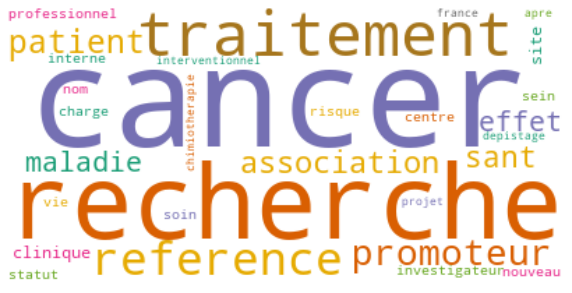

In [50]:

word_cloud(text_health_medical)


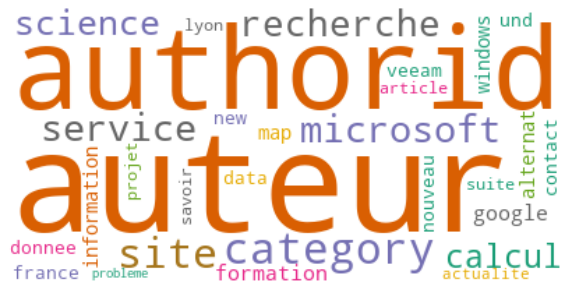

In [51]:
word_cloud(text_tech_science)

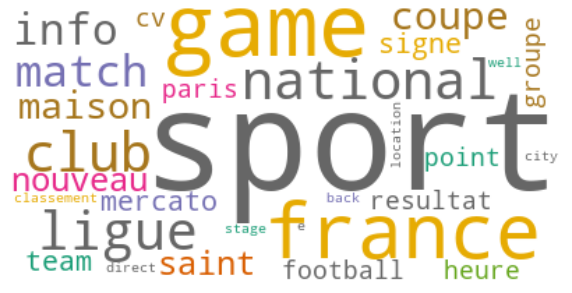

In [52]:
word_cloud(text_sports)

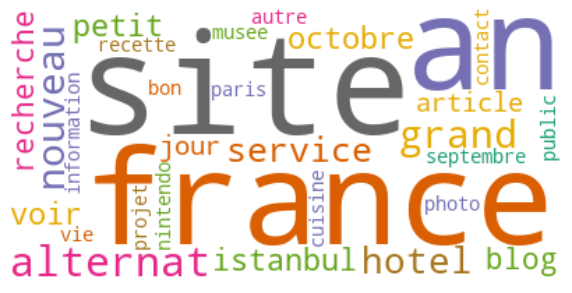

In [53]:
word_cloud(text_entertainment)

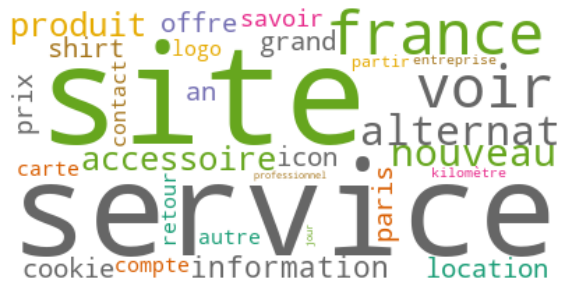

In [54]:
word_cloud(text_business_finance)

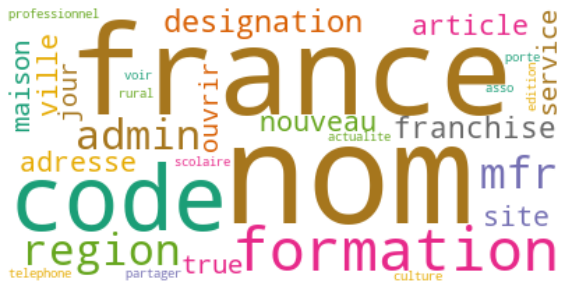

In [55]:
word_cloud(text_news_press)

## 7. Preprocessing : Part2

### Tokenization

In [183]:
from keras.preprocessing.text import Tokenizer

max_words = 150000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data_train['text'].values)

### Embedding

For word embedding, we used French word embeddings
models. It is about pre-trained word2vec models for French.
Their format is the same initial binary format proposed with
word2vec v0.1c. [Fauconnier, 2015] We used the embeddings
trained on the French web of dimensionality 200 and a count cutoff of 100.


frWaC: a 1.6 billion word corpus constructed from the Web limiting the crawl to the .fr domain and using medium-frequency words from the Le Monde Diplomatique corpus and basic French vocabulary lists as seeds. The corpus was POS-tagged and lemmatized with the TreeTagger(The TreeTagger is a tool for annotating text with part-of-speech and lemma information. )

In [201]:
!pip install unidecode
#!wget http://embeddings.net/frWac_non_lem_no_postag_no_phrase_200_cbow_cut100.bin
!curl http://embeddings.net/frWac_no_postag_no_phrase_500_skip_cut100.bin -o outfile

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  228M  100  228M    0     0   204k      0  0:19:02  0:19:02 --:--:--  463k44:30  120k4:49  0:01:09  0:43:40  102k     0  0:48:08  0:01:18  0:46:50  476252  0:37:31  242k    0  0:35:16  0:02:14  0:33:02  232k:02:22  0:30:37  186k  128k      0  0:30:24  0:02:50  0:27:34  190k8  0:26:22  157k  0:26:45  0:03:56  0:22:49  326k:01  0:22:01  324k9  0:05:08  0:20:51  262k:25:19  0:05:25  0:19:54  273k 0  0:27:14  0:06:21  0:20:53  104k06:31  0:21:04 512080:06:41  0:21:34  4786  0  0:29:33  0:07:02  0:22:31 37608  0  0:31:34  0:07:31  0:24:03  3364     0  0:31:57  0:07:37  0:24:20  88325359     0  0:33:21  0:07:58  0:25:23  5730   0  0:35:20  0:08:35  0:26:45 371163  0:08:46  0:26:47 78942:15  0:09:33  0:26:42 659180:09:34  0:26:43 5934826:51 45295 0  0:37:36  0:10:07  0:27:29 298690  0:38:42  0:10:36  0:28:06  3391  0:27:25  161k   10

In [202]:
embeds = KeyedVectors.load_word2vec_format('outfile', binary=True)

In [205]:
d = 500
word_index = tokenizer.word_index
embedding_matrix = np.zeros((max_words, d))

for word, i in word_index.items():
    if i >= max_words:
        continue
    try:
        embedding_vector = embeds[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        pass

### Smooth labels
To overcome the dirtiness of our text database (some pages
contained little to no text, others contained error pages) and make sure that the two latter models don’t get overconfident, we used label smoothing, as presented in [Muller et al.,2019]. 

Instead of using hard labels (represented by one-hot
encodings), we use soft probability vectors, where the probability of the true class is 0.9 and the others are equiprobable.
This slightly increases our cross-validation and test scores for
the final models.

In [170]:
def cnn_branch(n_filters, k_size, d_rate, my_input):
    return Dropout(d_rate)(GlobalMaxPooling1D()(Conv1D(filters=n_filters,
                                                       kernel_size=k_size,
                                                       activation='relu')(my_input)))

def smooth_labels(labels, factor=0.1):
    labels *= (1 - factor)
    labels += (factor / labels.shape[1])
    return labels



class CNNModel(BaseEstimator):
    def __init__(self):
        embedding_layer = Embedding(max_words,
                                    d,
                                    embeddings_initializer=Constant(embedding_matrix),
                                    input_length=max_size,
                                    trainable=True)
        doc_ints = Input(shape=(None,))
        doc_wv = embedding_layer(doc_ints)
        doc_wv_dr = Dropout(drop_rate)(doc_wv)

        branch_outputs = []

        for idx in range(nb_branches):
            branch_outputs.append(cnn_branch(nb_filters, filter_sizes[idx], drop_rate, doc_wv_dr))

        concat = Concatenate()(branch_outputs)
        preds = Dense(units=8, activation='softmax')(concat)
        self.model = Model(doc_ints, preds)

        self.model.compile(loss='categorical_crossentropy', optimizer=my_optimizer)
        self.le = preprocessing.LabelBinarizer()
        self.le.fit([u for u in labels])

    def fit(self, X_train, y_train):
        train_data = sequence.pad_sequences(tokenizer.texts_to_sequences([pattern.sub(' ', u[1]) for u in X_train]),
                                            maxlen=max_size)

        y_tr = self.le.transform([u for u in y_train])
        y_tr = smooth_labels(np.array(y_tr, dtype='float64'))
        res = self.model.fit(np.array(train_data), np.array(y_tr), batch_size=batch_size, epochs=nb_epochs)
        return res

    def predict_proba(self, X_test):
        test_data = sequence.pad_sequences(tokenizer.texts_to_sequences([pattern.sub(' ', u[1]) for u in X_test]),
                                           maxlen=max_size)
        return self.model.predict(test_data)

In [171]:
max_size = 1000
max_words = 150000
nb_branches = 2
nb_filters = 50
filter_sizes = [3, 4]
drop_rate = 0.3
batch_size = 64
nb_epochs = 3
my_optimizer = 'adam'
model = CNNModel()

In [172]:

def custom_cross_val(model, X_all, y_all):
    train_score, test_score = list(), list()
    for fold in range(5):
        print(f'Fold {fold + 1}...')
        X_train, X_test, y_train, y_test = train_test_split(X_all, y_all)
        model.fit(X_train, y_train)
        print('Model trained')
        train_score.append(log_loss(y_train, model.predict_proba(X_train)))
        test_score.append(log_loss(y_test, model.predict_proba(X_test)))
    return train_score, test_score


model = CNNModel()
X_all = data_train['text']
y_all = data_train['category']
train_score, test_score = custom_cross_val(model, X_all, y_all)
y_pred = model.predict_proba(X_test)


Fold 1...
Train on 1574 samples
Epoch 1/3
1574/1574 [==============================] - 44s 28ms/sample - loss: 1.8912
Epoch 2/3
1574/1574 [==============================] - 45s 28ms/sample - loss: 1.8368
Epoch 3/3
1574/1574 [==============================] - 43s 28ms/sample - loss: 1.8262
Fold 2...
Train on 1574 samples
Epoch 1/3
1574/1574 [==============================] - 44s 28ms/sample - loss: 1.8232
Epoch 2/3
1574/1574 [==============================] - 46s 29ms/sample - loss: 1.8210
Epoch 3/3
1574/1574 [==============================] - 46s 29ms/sample - loss: 1.8025
Fold 3...
Train on 1574 samples
Epoch 1/3
1574/1574 [==============================] - 44s 28ms/sample - loss: 1.8267
Epoch 2/3
1574/1574 [==============================] - 45s 29ms/sample - loss: 1.8290
Epoch 3/3
1574/1574 [==============================] - 45s 29ms/sample - loss: 1.8232
Fold 4...
Train on 1574 samples
Epoch 1/3
1574/1574 [==============================] - 44s 28ms/sample - loss: 1.8163
Epoch 2/3
15

## Local testing 

In [182]:
print(f'Cross val scores for train: mean {np.mean(train_score):06} - std {np.std(train_score):06}')
print(f'Cross val scores for test : mean {np.mean(test_score):06} - std {np.std(test_score):06}')

Cross val scores for train: mean 1.7351942617450917 - std 0.011446963182592949
Cross val scores for test : mean 1.7703995416277931 - std 0.02946825239495417


In [143]:
y_pred

array([[0.13944194, 0.29494277, 0.23051202, ..., 0.01955009, 0.06058479,
        0.16539927],
       [0.0923529 , 0.02260538, 0.76660615, ..., 0.00457621, 0.03114017,
        0.05661323],
       [0.7503451 , 0.00960993, 0.13655387, ..., 0.008203  , 0.0219424 ,
        0.02887657],
       ...,
       [0.24947278, 0.0947015 , 0.37635213, ..., 0.01860547, 0.05498748,
        0.07930963],
       [0.6462099 , 0.02290583, 0.19990122, ..., 0.01024902, 0.04922944,
        0.03232878],
       [0.01121595, 0.00697148, 0.01222001, ..., 0.00533822, 0.00368938,
        0.9381846 ]], dtype=float32)

## Save submissions

In [175]:
with open('./submissions.csv', 'w') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    lst = labels
    lst.insert(0, "Host")
    writer.writerow(lst)
    for i,test_host in enumerate(test_hosts):
        lst = y_pred[i,:].tolist()
        lst.insert(0, test_host)
        writer.writerow(lst)

print('Submission written successfully')

Submission written successfully
